In [37]:
import os
import datetime
import numpy as np 
import pandas as pd

import seaborn as sns 
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

import torch 
from torch import nn, optim 
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl 
from pytorch_lightning import seed_everything, LightningModule, Trainer

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(rc={'figure.figsize':(25, 8)})

# Download the dataset

In [38]:
datapath = '../data/Metro_Interstate_Traffic_Volume/'
df_traffic = pd.read_csv(os.path.join(datapath, 'Metro_Interstate_Traffic_Volume.csv'), parse_dates=['date_time'], index_col='date_time')
print(df_traffic.dtypes)
df_traffic.head()

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
traffic_volume           int64
dtype: object


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [39]:
print('Total number of row in dataset: ', df_traffic.shape[0])
print('Total number of columns in dataset: ', df_traffic.shape[1])

Total number of row in dataset:  48204
Total number of columns in dataset:  8


In [40]:
df_traffic.weather_main.value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [41]:
df_traffic.holiday.value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

In [42]:
df_traffic[df_traffic.index.duplicated()]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-10 07:00:00,None,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,6793
2012-10-10 08:00:00,None,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,6283
2012-10-10 09:00:00,None,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,5680
2012-10-14 09:00:00,None,282.43,0.0,0.0,57,Mist,mist,2685
2012-10-14 09:00:00,None,282.43,0.0,0.0,57,Haze,haze,2685
...,...,...,...,...,...,...,...,...
2018-09-25 16:00:00,None,284.25,0.0,0.0,90,Drizzle,light intensity drizzle,6597
2018-09-27 07:00:00,None,285.17,0.0,0.0,90,Drizzle,light intensity drizzle,6589
2018-09-29 19:00:00,None,280.68,0.0,0.0,90,Clouds,overcast clouds,3818


In [43]:
df_traffic = df_traffic[~df_traffic.index.duplicated(keep='last')]
df_traffic.shape

(40575, 8)

Text(0.5, 1.0, 'Traffic volume time series')

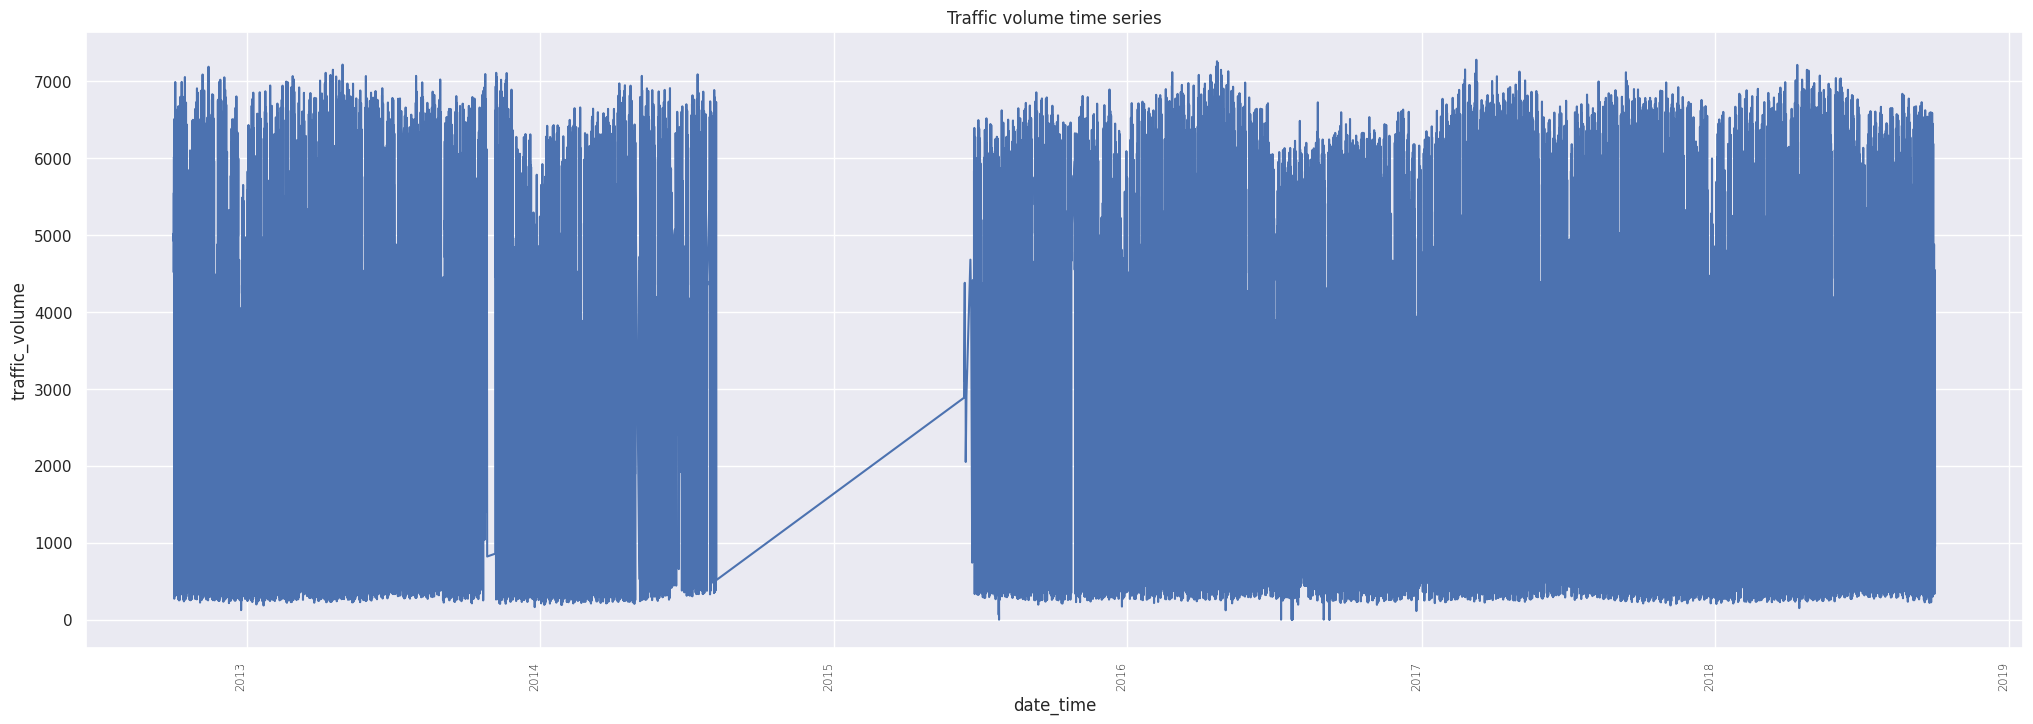

In [44]:
plt.xticks(
    rotation=90,
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'
)
sns.lineplot(df_traffic, x=df_traffic.index, y='traffic_volume').set_title('Traffic volume time series')

In [45]:
## check for missing values 
# dummy data 
date_range = pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq='1H')
df_dummy = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
df_dummy.index = date_range
df_missing = df_traffic 

# check for missing datetimeindex values based on reference index (with all values)
missing_hours = df_dummy.index.difference(df_missing.index)
print(missing_hours)
print(len(missing_hours))

DatetimeIndex(['2012-10-03 07:00:00', '2012-10-03 10:00:00',
               '2012-10-03 11:00:00', '2012-10-03 17:00:00',
               '2012-10-05 02:00:00', '2012-10-05 04:00:00',
               '2012-10-06 03:00:00', '2012-10-07 01:00:00',
               '2012-10-07 02:00:00', '2012-10-09 03:00:00',
               ...
               '2018-03-24 05:00:00', '2018-03-24 06:00:00',
               '2018-03-24 07:00:00', '2018-03-29 02:00:00',
               '2018-05-05 02:00:00', '2018-06-02 02:00:00',
               '2018-08-07 07:00:00', '2018-08-07 08:00:00',
               '2018-08-07 09:00:00', '2018-08-23 02:00:00'],
              dtype='datetime64[ns]', length=11976, freq=None)
11976


In [46]:
df_traffic.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
traffic_volume         0
dtype: int64

In [47]:
# Inserting missing hours
df_traffic = df_traffic.reindex(pd.date_range(df_traffic.head(1).index[0], df_traffic.tail(1).index[0], freq='1H'))
df_traffic.shape

(52551, 8)

In [48]:
df_traffic.isna().sum()

holiday                11976
temp                   11976
rain_1h                11976
snow_1h                11976
clouds_all             11976
weather_main           11976
weather_description    11976
traffic_volume         11976
dtype: int64

In [49]:
df_traffic['temp'].describe()

count    40575.000000
mean       281.315009
std         13.818404
min          0.000000
25%        271.840000
50%        282.860000
75%        292.280000
max        310.070000
Name: temp, dtype: float64

In [50]:
# Fill the temp value with median since 0 degree Kelvin is not possible 
df_traffic['temp'] = df_traffic['temp'].fillna(df_traffic['temp'].median())

In [51]:
# Selecting only last 3 years data for further analysis
df_traffic = df_traffic[df_traffic.index.year.isin([2016, 2017, 2018])].copy()

# Filling missing values using backfill and interpolation methods 
df_traffic = pd.concat([
    df_traffic.select_dtypes(include=['object']).fillna(method='bfill'), 
    df_traffic.select_dtypes(include=['float64']).interpolate()
], axis=1)
df_traffic.shape

(24096, 8)

In [52]:
df_traffic = pd.get_dummies(df_traffic, columns=['holiday', 'weather_main'], drop_first=True)

In [53]:
df_traffic.drop('weather_description', axis=1, inplace=True)

In [54]:
print('Date starting from: ', df_traffic.index.min())
print('Date ending at: ', df_traffic.index.max())

Date starting from:  2016-01-01 00:00:00
Date ending at:  2018-09-30 23:00:00


In [55]:
df_traffic_train = df_traffic.loc[:datetime.datetime(2017, 12, 31, 23)]

print('Total number of row in train dataset: ', df_traffic_train.shape[0])
print('Train dataset start date: ', df_traffic_train.index.min())
print('Train dataset end date: ', df_traffic_train.index.max())

Total number of row in train dataset:  17544
Train dataset start date:  2016-01-01 00:00:00
Train dataset end date:  2017-12-31 23:00:00


In [56]:
df_traffic_val = df_traffic.loc[datetime.datetime(2018, 1, 1, 0): datetime.datetime(2018, 6, 30, 23)]

print('Total number of row in validation dataset: ', df_traffic_val.shape[0])
print('Validation dataset start date: ', df_traffic_val.index.min())
print('Validation dataset end date: ', df_traffic_val.index.max())

Total number of row in validation dataset:  4344
Validation dataset start date:  2018-01-01 00:00:00
Validation dataset end date:  2018-06-30 23:00:00


In [57]:
df_traffic_test = df_traffic.loc[datetime.datetime(2018, 7, 1, 0): ]

print('Total number of row in test dataset: ', df_traffic_test.shape[0])
print('Test dataset start date: ', df_traffic_test.index.min())
print('Test dataset end date: ', df_traffic_test.index.max())

Total number of row in test dataset:  2208
Test dataset start date:  2018-07-01 00:00:00
Test dataset end date:  2018-09-30 23:00:00


In [58]:
df_traffic_train.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
2016-01-01 00:00:00,265.94,0.0,0.0,90.0,1513.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 01:00:00,266.00,0.0,0.0,90.0,1550.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 02:00:00,282.86,0.0,0.0,90.0,1134.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 03:00:00,266.01,0.0,0.0,90.0,719.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 04:00:00,264.80,0.0,0.0,90.0,533.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [59]:
# Create scalers 
temp_scaler = MinMaxScaler()
rain_scaler = MinMaxScaler()
snow_scaler = MinMaxScaler()
cloud_scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()

# Create transformers 
temp_scaler_transformer = temp_scaler.fit(df_traffic_train[['temp']])
rain_scaler_transformer = rain_scaler.fit(df_traffic_train[['rain_1h']])
snow_scaler_transformer = snow_scaler.fit(df_traffic_train[['snow_1h']])
cloud_scaler_transformer = cloud_scaler.fit(df_traffic_train[['clouds_all']])
volume_scaler_transformer = volume_scaler.fit(df_traffic_train[['traffic_volume']])

In [60]:
# Apply scaling to validate dataset 
df_traffic_train['temp'] = temp_scaler_transformer.transform(df_traffic_train[['temp']])
df_traffic_train['rain_1h'] = rain_scaler_transformer.transform(df_traffic_train[['rain_1h']])
df_traffic_train['snow_1h'] = snow_scaler_transformer.transform(df_traffic_train[['snow_1h']])
df_traffic_train['clouds_all'] = cloud_scaler_transformer.transform(df_traffic_train[['clouds_all']])
df_traffic_train['traffic_volume'] = volume_scaler_transformer.transform(df_traffic_train[['traffic_volume']])

In [61]:
#Apply scaling to validate dataset
df_traffic_val["temp"] = temp_scaler_transformer.transform(df_traffic_val[['temp']])
df_traffic_val["rain_1h"] = rain_scaler_transformer.transform(df_traffic_val[['rain_1h']])
df_traffic_val["snow_1h"] = snow_scaler_transformer.transform(df_traffic_val[['snow_1h']])
df_traffic_val["clouds_all"] = cloud_scaler_transformer.transform(df_traffic_val[['clouds_all']])
df_traffic_val["traffic_volume"] = volume_scaler_transformer.transform(df_traffic_val[['traffic_volume']])

#Apply scaling to test dataset
df_traffic_test["temp"] = temp_scaler_transformer.transform(df_traffic_test[['temp']])
df_traffic_test["rain_1h"] = rain_scaler_transformer.transform(df_traffic_test[['rain_1h']])
# df_traffic_test["snow_1h"] = snow_scaler_transformer.transform(df_traffic_test[['snow_1h']])
df_traffic_test["clouds_all"] = cloud_scaler_transformer.transform(df_traffic_test[['clouds_all']])
df_traffic_test["traffic_volume"] = volume_scaler_transformer.transform(df_traffic_test[['traffic_volume']])

In [62]:
class TrafficVolumeDataset(Dataset):
    def __init__(self, train=False, val=False, test=False, window_size=480):

        # STEP1: Load the data
        self.df_traffic_train = df_traffic_train
        self.df_traffic_val = df_traffic_val
        self.df_traffic_test = df_traffic_test

        # STEP2: Creating Features
        if train:
            features = self.df_traffic_train 
            target = self.df_traffic_train['traffic_volume']
        elif val:
            features = self.df_traffic_val
            target = self.df_traffic_val['traffic_volume']
        else:
            features = self.df_traffic_test
            target = self.df_traffic_test['traffic_volume']
        
        # STEP3: Create windows/sequencing 
        self.x, self.y = [], []
        for i in range(len(features) - window_size):
            v = features.iloc[i: (i + window_size)].values
            self.x.append(v)
            self.y.append(target.iloc[i + window_size])
        
        # STEP4: Calculate length of dataset
        self.num_sample = len(self.x)
    
    def __len__(self):
        return self.num_sample

    def __getitem__(self, index):
        x = self.x[index].astype(np.float32)
        y = self.y[index].astype(np.float32)
        return x, y

In [63]:
class TrafficVolumePrediction(LightningModule):

    def __init__(self, input_size=26, output_size=1, hidden_dim=10, n_layers=2, window_size=480):
        """
        Args:
            input_size: int, number of features in the input 
            hidden_dim: int, number of hidden layers 
            n_layers: int, number of RNN to stack over each other 
            output_size: int, number of items to be outputted
        """
        super(TrafficVolumePrediction, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.TrafficVolumePrediction = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim * window_size, output_size)

        self.loss = nn.MSELoss()

        self.learning_rate=1e-3

    def forward(self, x):
        hidden = self.get_hidden(x)
        out, hidden = self.TrafficVolumePrediction(x, hidden)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out
        
    def get_hidden(self, x):
        hidden_state = torch.zeros((self.n_layers, x.size(0), self.hidden_dim), device=x.device)
        cell_state = torch.zeros((self.n_layers, x.size(0), self.hidden_dim), device=x.device)
        hidden = (hidden_state, cell_state)
        return hidden 
    
    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        features, targets = batch 
        outputs = self(features)
        outputs = outputs.view(-1)
        loss = self.loss(outputs, targets)
        self.log('train_loss', loss, prog_bar=True)
        return {'loss': loss}
    
    def train_dataloader(self):
        traffic_volume_train = TrafficVolumeDataset(train=True)
        train_dataloader = DataLoader(traffic_volume_train, batch_size=50)
        return train_dataloader
    
    def validation_step(self, batch, batch_idx):
        features, targets = batch 
        outputs = self(features)
        outputs = outputs.view(-1)
        loss = self.loss(outputs, targets)
        self.log('val_loss', loss, prog_bar=True)
    
    def val_dataloader(self):
        traffic_volume_val = TrafficVolumeDataset(val=True)
        val_dataloader = DataLoader(traffic_volume_val, batch_size=50)
        return val_dataloader

In [64]:
seed_everything(10)
model = TrafficVolumePrediction()
trainer = Trainer(default_root_dir='traffic_prediction_LSTM_ckpts', max_epochs=140, accelerator='gpu', devices=[5])

Global seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [65]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                    | Type    | Params
----------------------------------------------------
0 | TrafficVolumePrediction | LSTM    | 2.4 K 
1 | fc                      | Linear  | 4.8 K 
2 | loss                    | MSELoss | 0     
----------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/CeoxNim/anaconda3/envs/pl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/CeoxNim/anaconda3/envs/pl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=140` reached.


In [70]:
# Load checkpoint 
version = 2
ckpt_path = f'traffic_prediction_LSTM_ckpts/lightning_logs/version_{version}/checkpoints'
ckpt_path = os.path.join(ckpt_path, os.listdir(ckpt_path)[0])
trained_traffic_volume_TrafficVolumePrediction = model.load_from_checkpoint(ckpt_path)
trained_traffic_volume_TrafficVolumePrediction.eval()

TrafficVolumePrediction(
  (TrafficVolumePrediction): LSTM(26, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4800, out_features=1, bias=True)
  (loss): MSELoss()
)

In [71]:
# Initialize Dataset 
traiffic_volume_test_dataset = TrafficVolumeDataset(test=True)
traiffic_volume_test_dataloader = DataLoader(traiffic_volume_test_dataset, batch_size=20)
preds, actuals = [], []
for i, (features, targets) in enumerate(traiffic_volume_test_dataloader):
    outputs = trained_traffic_volume_TrafficVolumePrediction(features)
    preds.extend(outputs.detach().view(-1).tolist())
    actuals.extend(targets.detach().view(-1).tolist())

In [72]:
acturals_preds_df = pd.DataFrame({'actuals': actuals, 'preds': preds})
inverse_transformed_values = volume_scaler_transformer.inverse_transform(acturals_preds_df)
acturals_preds_df['actuals'] = inverse_transformed_values[:, 0]
acturals_preds_df['preds'] = inverse_transformed_values[:, 1]
acturals_preds_df

,actuals,preds
0,1234.999954,1412.151897
1,780.999981,894.652402
2,648.000016,656.656485
3,418.000002,261.012433
4,478.000026,558.250394
...,...,...
1723,3543.000033,3612.658587
1724,2780.999916,3145.108700
1725,2158.999898,2659.514391
1726,1449.999968,2195.765226


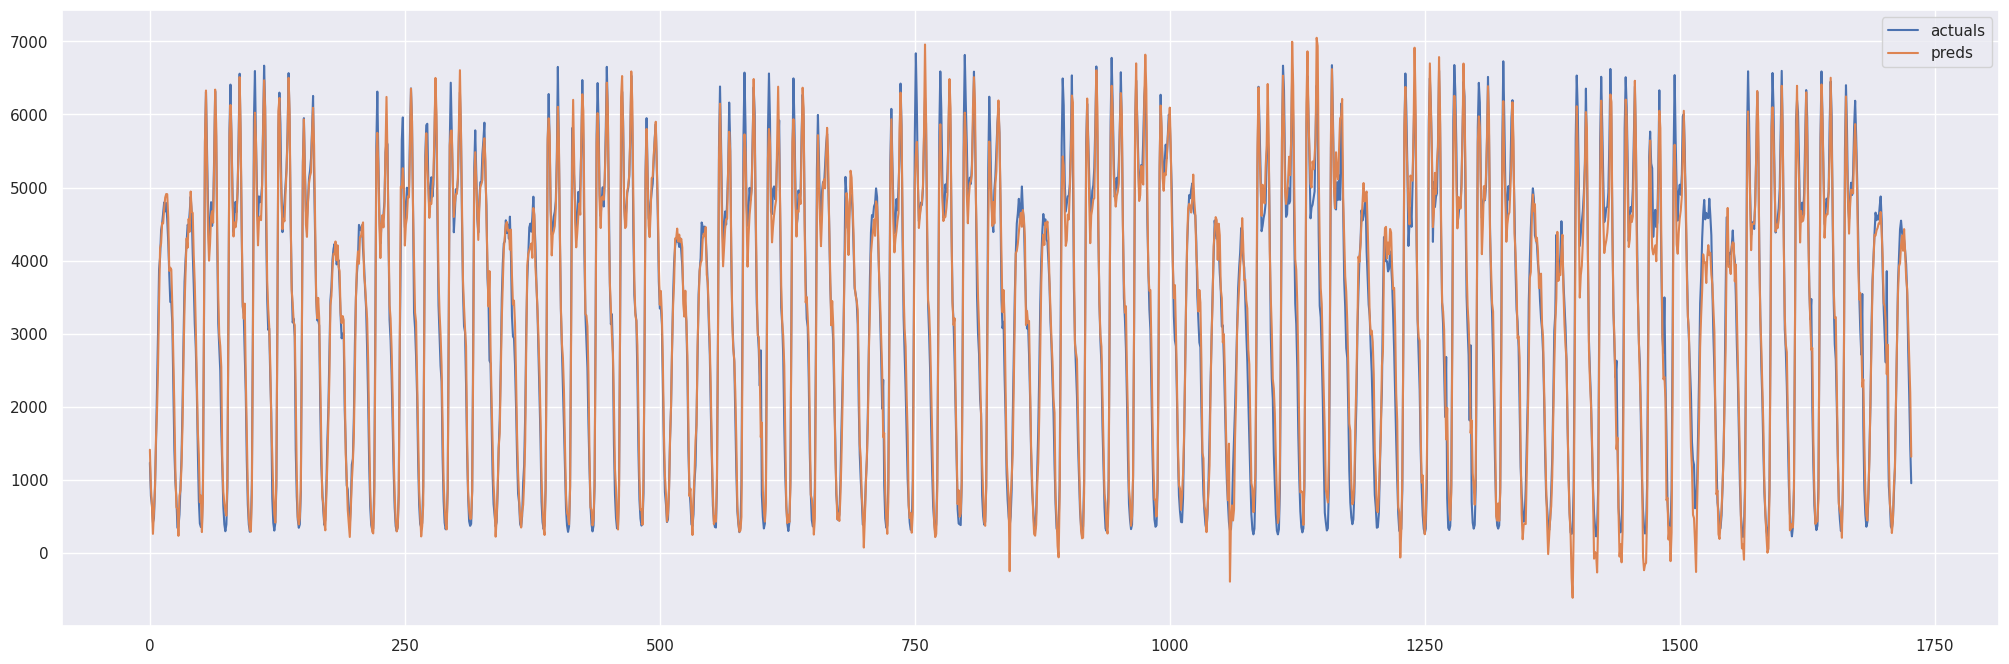

In [74]:
plt.plot(acturals_preds_df['actuals'], label='actuals')
plt.plot(acturals_preds_df['preds'], label='preds')
plt.legend()
plt.show()